## Funcion

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import math

import json
import math
import networkx as nx

def cargar_datos(json_files):
    data_comb = {"rs_info": None, "stations": set(), "services": {}, "cost_per_unit": {}}
    for file_path in json_files:
        with open(file_path, "r") as file:
            data = json.load(file)
        
        # Unificar rs_info (usar el primero como base)
        if data_comb["rs_info"] is None:
            data_comb["rs_info"] = data["rs_info"]
        
        # Agregar estaciones
        data_comb["stations"].update(data["stations"])
        
        # Agregar servicios
        for service_id, service in data["services"].items():
            data_comb["services"][service_id] = service
        
        # Agregar costos por unidad
        for station, cost in data["cost_per_unit"].items():
            data_comb["cost_per_unit"][station] = cost
    
    data_comb["stations"] = list(data_comb["stations"])
    return data_comb

def modelo(G, flow_dict, stations):
    # Dibujar circulación
    pos = {}
    for i, (node, datos) in enumerate(G.nodes(data=True)):
        station_i= stations.index(datos["station"])
        pos[node] = (datos["time"] + i * 10, station_i)  

    # Dibujar nodos con un tamaño más grande y color claro
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue", alpha=0.7)

    # Dibujar las etiquetas de los nodos
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")


    for (u, v, datos) in G.edges(data=True):
        color = datos['color']
        if color == 'green':
            connectionstyle = 'arc3,rad=0.2'  
        else:
            connectionstyle = 'arc3,rad=0'  
        
        # Dibujar la arista
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], edge_color=color, width=2,
            arrowstyle="->", arrowsize=10, alpha=1, connectionstyle=connectionstyle
        )


    plt.title("Grafo de flujo de trenes ", fontsize=16)
    plt.xlabel("Tiempo (Unidades de Tiempo)", fontsize=12)
    plt.ylabel("Estación (Índice)", fontsize=12)

    plt.show()


def circulacion(data, dibujo=False):

    data= cargar_datos(data)

    # Crear el grafo dirigido
    G = nx.DiGraph()

    # Parámetros generales
    capacity = data["rs_info"]["capacity"]
    max_rs = data["rs_info"]["max_rs"]
    stations = data["stations"]
    cost_per_unit = data["cost_per_unit"]

    #Agregar tren al grafo
    for service_id, service in data["services"].items():
        stops = service["stops"]
        demand = service["demand"][0]

        # Crear nodos para las estaciones
        salida = f"{service_id}_D"
        llegada = f"{service_id}_A"
        
        G.add_node(salida, station=stops[0]["station"], time=stops[0]["time"], demand=math.ceil(demand / capacity))
        G.add_node(llegada, station=stops[1]["station"], time=stops[1]["time"], demand=-math.ceil(demand / capacity))

        # Agregar arista
        G.add_edge(
            salida,
            llegada,
            lower=math.ceil(demand / capacity),  
            upper=max_rs,  
            costo=0, 
            color='blue' 
        )

    #Agregar traspaso por estación
    eventos_station = {station: [] for station in stations}
    for node, attributes in G.nodes(data=True):
        eventos_station[attributes["station"]].append((node, attributes["time"]))

    for station, events in eventos_station.items():
        # Ordenar eventos por tiempo dentro de la misma estación
        events.sort(key=lambda x: x[1])
        for i in range(len(events) - 1):
            G.add_edge(
                events[i][0],
                events[i + 1][0],
                lower=0,
                upper=float('inf'), 
                costo=0,  
                color='red' 
            )

    # Agregar trasnoche 
    for station, events in eventos_station.items():
        if events:
            salida = events[0][0]
            llegada = events[-1][0]
            
            G.add_edge(
                llegada,
                salida,
                lower=0,
                upper=1e10,  
                costo=cost_per_unit[station], 
                color='green'  
            )

    # 4. Resolver flujo mínimo y calcular costos
    flow_cost, flow_dict = nx.capacity_scaling(G, demand='demand', weight='costo')

    # Mostrar resultados en texto
    print("Costo mínimo (vagones):", flow_cost)
    print("\nFlujo por arco:")
    for u, v, attributes in G.edges(data=True):
        flujo = flow_dict.get(u, {}).get(v)
        print(f"{u} -> {v}: Flujo = {flujo}, Costo = {attributes['costo']}")

    # Llamar a la función de dibujo si se solicita
    if dibujo:
        modelo(G, flow_dict, stations)



## Modelo

Costo mínimo (vagones): 15.0

Flujo por arco:
1_D -> 1_A: Flujo = 0, Costo = 0
1_D -> 3_A: Flujo = 0, Costo = 0
1_A -> 2_A: Flujo = 5, Costo = 0
2_D -> 2_A: Flujo = 0, Costo = 0
2_D -> 4_A: Flujo = 0, Costo = 0
2_A -> 3_D: Flujo = 10, Costo = 1.0
3_D -> 3_A: Flujo = 0, Costo = 0
3_D -> 4_D: Flujo = 5, Costo = 0
3_A -> 2_D: Flujo = 5, Costo = 0
4_D -> 4_A: Flujo = 0, Costo = 0
4_D -> 1_A: Flujo = 0, Costo = 0
4_A -> 1_D: Flujo = 5, Costo = 1.0


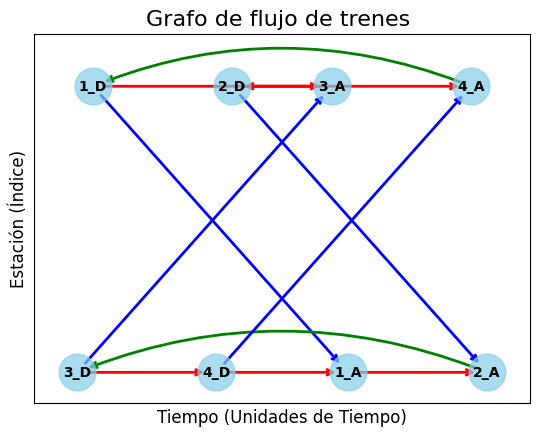

In [53]:
circulacion([r"..\instances\toy_instance.json"], True)

## Ejercicio 4
Creo un json a partir de los 3 y comparo con usar los ramales independientemente

JSON usando los valores en conjunto de los ramales:

In [54]:
data_comb = [r"C:\Users\olini\OneDrive\Documentos\ditella\td5\tp2\instances\retiro-victoria-semana.json", r"C:\Users\olini\OneDrive\Documentos\ditella\td5\tp2\instances\tigre-victoria-semana.json", r"C:\Users\olini\OneDrive\Documentos\ditella\td5\tp2\instances\cardales-victoria-semana.json"]
circulacion(data_comb)

Costo mínimo (vagones): 50.0

Flujo por arco:
3001_D -> 3001_A: Flujo = 20, Costo = 0
3001_D -> 3018_A: Flujo = 6, Costo = 0
3001_A -> 3022_D: Flujo = 25, Costo = 0
3003_D -> 3003_A: Flujo = 11, Costo = 0
3003_D -> 3020_A: Flujo = 3, Costo = 0
3003_A -> 3024_D: Flujo = 20, Costo = 0
3005_D -> 3005_A: Flujo = 4, Costo = 0
3005_D -> 3022_A: Flujo = 0, Costo = 0
3005_A -> 3026_D: Flujo = 9, Costo = 0
3007_D -> 3007_A: Flujo = 15, Costo = 0
3007_D -> 3024_A: Flujo = 1, Costo = 0
3007_A -> 3028_D: Flujo = 20, Costo = 0
3009_D -> 3009_A: Flujo = 16, Costo = 0
3009_D -> 3026_A: Flujo = 0, Costo = 0
3009_A -> 3030_D: Flujo = 21, Costo = 0
3011_D -> 3011_A: Flujo = 4, Costo = 0
3011_D -> 2002_A: Flujo = 0, Costo = 0
3011_A -> 3032_D: Flujo = 9, Costo = 0
3013_D -> 3013_A: Flujo = 19, Costo = 0
3013_D -> 3030_A: Flujo = 1, Costo = 0
3013_A -> 3034_D: Flujo = 24, Costo = 0
3015_D -> 3015_A: Flujo = 16, Costo = 0
3015_D -> 3032_A: Flujo = 1, Costo = 0
3015_A -> 3036_D: Flujo = 25, Costo = 0
3017_D

Calculo de forma independiente el uso de vagones para los dos ramales:

In [55]:
#retiro- tigre
data_1= [r"C:\Users\olini\OneDrive\Documentos\ditella\td5\tp2\instances\retiro-tigre-semana.json"]
circulacion(data_1)

Costo mínimo (vagones): 55.0

Flujo por arco:
3001_D -> 3001_A: Flujo = 0, Costo = 0
3001_D -> 3003_D: Flujo = 5, Costo = 0
3001_A -> 3022_D: Flujo = 5, Costo = 0
3003_D -> 3003_A: Flujo = 0, Costo = 0
3003_D -> 3006_A: Flujo = 0, Costo = 0
3003_A -> 3024_D: Flujo = 5, Costo = 0
3005_D -> 3005_A: Flujo = 6, Costo = 0
3005_D -> 3008_A: Flujo = 1, Costo = 0
3005_A -> 3026_D: Flujo = 11, Costo = 0
3007_D -> 3007_A: Flujo = 0, Costo = 0
3007_D -> 3010_A: Flujo = 1, Costo = 0
3007_A -> 3028_D: Flujo = 5, Costo = 0
3009_D -> 3009_A: Flujo = 0, Costo = 0
3009_D -> 3012_A: Flujo = 1, Costo = 0
3009_A -> 3030_D: Flujo = 5, Costo = 0
3011_D -> 3011_A: Flujo = 3, Costo = 0
3011_D -> 3014_A: Flujo = 0, Costo = 0
3011_A -> 3032_D: Flujo = 8, Costo = 0
3013_D -> 3013_A: Flujo = 0, Costo = 0
3013_D -> 3016_A: Flujo = 0, Costo = 0
3013_A -> 3034_D: Flujo = 5, Costo = 0
3015_D -> 3015_A: Flujo = 1, Costo = 0
3015_D -> 3018_A: Flujo = 0, Costo = 0
3015_A -> 3036_D: Flujo = 6, Costo = 0
3017_D -> 3017_A:

In [56]:
#victoria- cardales
data_2 =   [r"C:\Users\olini\OneDrive\Documentos\ditella\td5\tp2\instances\cardales-victoria-semana.json"]
circulacion(data_2)

Costo mínimo (vagones): 10.0

Flujo por arco:
2002_D -> 2002_A: Flujo = 0, Costo = 0
2002_D -> 2005_A: Flujo = 0, Costo = 0
2002_A -> 2005_D: Flujo = 10, Costo = 0
2006_D -> 2006_A: Flujo = 0, Costo = 0
2006_D -> 2007_A: Flujo = 0, Costo = 0
2006_A -> 2009_D: Flujo = 5, Costo = 0
2008_D -> 2008_A: Flujo = 0, Costo = 0
2008_D -> 2009_A: Flujo = 0, Costo = 0
2008_A -> 2011_D: Flujo = 5, Costo = 0
2010_D -> 2010_A: Flujo = 0, Costo = 0
2010_D -> 2011_A: Flujo = 0, Costo = 0
2010_A -> 2013_D: Flujo = 5, Costo = 0
2012_D -> 2012_A: Flujo = 0, Costo = 0
2012_D -> 2013_A: Flujo = 0, Costo = 0
2012_A -> 2015_D: Flujo = 5, Costo = 0
2014_D -> 2014_A: Flujo = 0, Costo = 0
2014_D -> 2015_A: Flujo = 0, Costo = 0
2014_A -> 2017_D: Flujo = 5, Costo = 0
2016_D -> 2016_A: Flujo = 0, Costo = 0
2016_D -> 2017_A: Flujo = 0, Costo = 0
2016_A -> 2018_A: Flujo = 5, Costo = 0
2018_D -> 2018_A: Flujo = 0, Costo = 0
2018_D -> 2001_A: Flujo = 0, Costo = 1.0
2018_A -> 2001_D: Flujo = 10, Costo = 1.0
2001_D -> 20

## Experimentacion

### Demandas
Queriamos ver si cambiabamos la demanda cuanto cambiaba la cantidad de vagones necesarios y si la necesidad es lineal a la demanda

#### Demanda Baja:
Con demanda igual siempre en 100

Costo mínimo (vagones): 2

Flujo por arco:
2001_D -> 2001_A: Flujo = 0, Costo = 0
2001_D -> 2002_A: Flujo = 1, Costo = 0
2001_A -> 2002_D: Flujo = 1, Costo = 0
2002_D -> 2002_A: Flujo = 0, Costo = 0
2002_D -> 2005_A: Flujo = 0, Costo = 0
2002_A -> 2005_D: Flujo = 2, Costo = 0
2005_D -> 2005_A: Flujo = 0, Costo = 0
2005_D -> 2007_D: Flujo = 1, Costo = 0
2005_A -> 2006_D: Flujo = 1, Costo = 0
2006_D -> 2006_A: Flujo = 0, Costo = 0
2006_D -> 2007_A: Flujo = 0, Costo = 0
2006_A -> 2009_D: Flujo = 1, Costo = 0
2007_D -> 2007_A: Flujo = 0, Costo = 0
2007_D -> 2006_A: Flujo = 0, Costo = 0
2007_A -> 2008_D: Flujo = 1, Costo = 0
2008_D -> 2008_A: Flujo = 0, Costo = 0
2008_D -> 2009_A: Flujo = 0, Costo = 0
2008_A -> 2011_D: Flujo = 1, Costo = 0
2009_D -> 2009_A: Flujo = 0, Costo = 0
2009_D -> 2008_A: Flujo = 0, Costo = 0
2009_A -> 2010_D: Flujo = 1, Costo = 0
2010_D -> 2010_A: Flujo = 0, Costo = 0
2010_D -> 2011_A: Flujo = 0, Costo = 0
2010_A -> 2013_D: Flujo = 1, Costo = 0
2011_D -> 2011_A: Flu

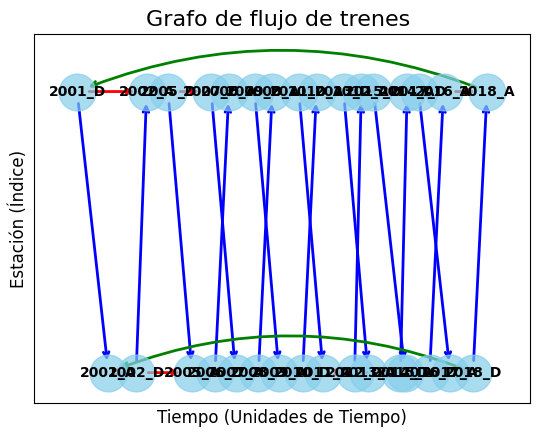

In [57]:
path = [r"..\instances\experimentacion\demandas\demanda_baja.json"]
circulacion(path, True)

#### Demanda Alta:
Con demanda en todas las estaciones constante en 1000 

In [58]:
path = [r"..\instances\experimentacion\demandas\demanda_alta.json"]
circulacion(path)

Costo mínimo (vagones): 20

Flujo por arco:
2001_D -> 2001_A: Flujo = 0, Costo = 0
2001_D -> 2002_A: Flujo = 10, Costo = 0
2001_A -> 2002_D: Flujo = 10, Costo = 0
2002_D -> 2002_A: Flujo = 0, Costo = 0
2002_D -> 2005_A: Flujo = 0, Costo = 0
2002_A -> 2005_D: Flujo = 20, Costo = 0
2005_D -> 2005_A: Flujo = 0, Costo = 0
2005_D -> 2007_D: Flujo = 10, Costo = 0
2005_A -> 2006_D: Flujo = 10, Costo = 0
2006_D -> 2006_A: Flujo = 0, Costo = 0
2006_D -> 2007_A: Flujo = 0, Costo = 0
2006_A -> 2009_D: Flujo = 10, Costo = 0
2007_D -> 2007_A: Flujo = 0, Costo = 0
2007_D -> 2006_A: Flujo = 0, Costo = 0
2007_A -> 2008_D: Flujo = 10, Costo = 0
2008_D -> 2008_A: Flujo = 0, Costo = 0
2008_D -> 2009_A: Flujo = 0, Costo = 0
2008_A -> 2011_D: Flujo = 10, Costo = 0
2009_D -> 2009_A: Flujo = 0, Costo = 0
2009_D -> 2008_A: Flujo = 0, Costo = 0
2009_A -> 2010_D: Flujo = 10, Costo = 0
2010_D -> 2010_A: Flujo = 0, Costo = 0
2010_D -> 2011_A: Flujo = 0, Costo = 0
2010_A -> 2013_D: Flujo = 10, Costo = 0
2011_D -> 

In [59]:
path= [r"..\instances\experimentacion\demandas\demanda_mixta.json"]
circulacion(path)

Costo mínimo (vagones): 34

Flujo por arco:
2001_D -> 2001_A: Flujo = 22, Costo = 0
2001_D -> 2002_A: Flujo = 6, Costo = 0
2001_A -> 2002_D: Flujo = 28, Costo = 0
2002_D -> 2002_A: Flujo = 0, Costo = 0
2002_D -> 2005_A: Flujo = 16, Costo = 0
2002_A -> 2005_D: Flujo = 18, Costo = 0
2005_D -> 2005_A: Flujo = 7, Costo = 0
2005_D -> 2007_D: Flujo = 6, Costo = 0
2005_A -> 2006_D: Flujo = 28, Costo = 0
2006_D -> 2006_A: Flujo = 0, Costo = 0
2006_D -> 2007_A: Flujo = 8, Costo = 0
2006_A -> 2009_D: Flujo = 20, Costo = 0
2007_D -> 2007_A: Flujo = 3, Costo = 0
2007_D -> 2006_A: Flujo = 0, Costo = 0
2007_A -> 2008_D: Flujo = 14, Costo = 0
2008_D -> 2008_A: Flujo = 0, Costo = 0
2008_D -> 2009_A: Flujo = 0, Costo = 0
2008_A -> 2011_D: Flujo = 14, Costo = 0
2009_D -> 2009_A: Flujo = 13, Costo = 0
2009_D -> 2008_A: Flujo = 0, Costo = 0
2009_A -> 2010_D: Flujo = 20, Costo = 0
2010_D -> 2010_A: Flujo = 11, Costo = 0
2010_D -> 2011_A: Flujo = 0, Costo = 0
2010_A -> 2013_D: Flujo = 22, Costo = 0
2011_D -